In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
from scipy.stats import geom
from scipy.optimize import minimize

In [2]:
apple = pd.read_csv(r"D:\data\aapl.us.txt")

apple.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,<OPENINT>
0,AAPL.US,D,19840907,0,0.10122,0.10246,0.10000,0.10122,97236149,0
1,AAPL.US,D,19840910,0,0.10122,0.10153,0.09878,0.10062,75471114,0
2,AAPL.US,D,19840911,0,0.10153,0.10428,0.10153,0.10246,177965367,0
3,AAPL.US,D,19840912,0,0.10246,0.10306,0.09938,0.09938,155467926,0
4,AAPL.US,D,19840913,0,0.10490,0.10520,0.10490,0.10490,242135546,0


In [3]:
apple['<DATE>'] = pd.to_datetime(apple['<DATE>'], format="%Y%m%d")
apple.dtypes
apple.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,<OPENINT>
0,AAPL.US,D,1984-09-07,0,0.10122,0.10246,0.10000,0.10122,97236149,0
1,AAPL.US,D,1984-09-10,0,0.10122,0.10153,0.09878,0.10062,75471114,0
2,AAPL.US,D,1984-09-11,0,0.10153,0.10428,0.10153,0.10246,177965367,0
3,AAPL.US,D,1984-09-12,0,0.10246,0.10306,0.09938,0.09938,155467926,0
4,AAPL.US,D,1984-09-13,0,0.10490,0.10520,0.10490,0.10490,242135546,0


In [4]:
apple.columns = apple.columns.str.strip().str.strip("<>").str.upper()

In [5]:
apple['DayOfWeek'] = apple['DATE'].dt.day_name()
apple.tail()

,TICKER,PER,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,OPENINT,DayOfWeek
9479,AAPL.US,D,2022-04-18,0,163.92,166.5984,163.57,165.07,69023941,0,Monday
9480,AAPL.US,D,2022-04-19,0,165.02,167.8200,163.91,167.40,67723833,0,Tuesday
9481,AAPL.US,D,2022-04-20,0,168.76,168.8800,166.10,167.23,67929814,0,Wednesday
9482,AAPL.US,D,2022-04-21,0,168.91,171.5300,165.91,166.42,87227768,0,Thursday
9483,AAPL.US,D,2022-04-22,0,166.46,167.8699,161.50,161.79,84753396,0,Friday


In [6]:
apple['weekday'] = apple['DATE'].dt.weekday         # Mon=0 ... Sun=6
apple['week']    = apple['DATE'].dt.to_period('W-MON')

In [7]:
tue_open = (apple.loc[apple['weekday'] == 1]        # Tuesday
                 .groupby('week')['OPEN']
                 .first()
                 .rename('buy_tue_open'))

thu_open = (apple.loc[apple['weekday'] == 3]        # Thursday
                 .groupby('week')['OPEN']
                 .first()
                 .rename('sell_thu_open'))
tue_open.head()

week
1984-09-11/1984-09-17    0.10153
1984-09-18/1984-09-24    0.10918
1984-09-25/1984-10-01    0.10122
1984-10-02/1984-10-08    0.09419
1984-10-09/1984-10-15    0.09481
Freq: W-MON, Name: buy_tue_open, dtype: float64

In [8]:
weekly = pd.concat([tue_open, thu_open], axis=1).dropna()  
weekly['net%'] = ((weekly['sell_thu_open'] / weekly['buy_tue_open']) - 1.0)*100.0
weekly.head()

,buy_tue_open,sell_thu_open,net%
week,,,
1984-09-11/1984-09-17,0.10153,0.10490,3.319216
1984-09-18/1984-09-24,0.10918,0.10336,-5.330647
1984-09-25/1984-10-01,0.10122,0.09817,-3.013238
1984-10-02/1984-10-08,0.09419,0.09692,2.898397
1984-10-09/1984-10-15,0.09481,0.09112,-3.891995


In [9]:
weekly['week_type'] = np.where(
    weekly['net%'] <= 0, 'bad week', 'good week'
)
weekly.head()

,buy_tue_open,sell_thu_open,net%,week_type
week,,,,
1984-09-11/1984-09-17,0.10153,0.10490,3.319216,good week
1984-09-18/1984-09-24,0.10918,0.10336,-5.330647,bad week
1984-09-25/1984-10-01,0.10122,0.09817,-3.013238,bad week
1984-10-02/1984-10-08,0.09419,0.09692,2.898397,good week
1984-10-09/1984-10-15,0.09481,0.09112,-3.891995,bad week


In [10]:
counts = weekly['week_type'].value_counts()
counts 

week_type
good week    966
bad week     922
Name: count, dtype: int64

### Analysis of Metrics for Classification

1. **Considering No Profit as Bad**:
    - In this scenario, the dataset is fairly balanced (51.2% bad weeks and 48.8% good weeks).
    - Since the goal is to maximize profit and no profit is treated as bad, the focus should be on **Recall** for the positive class (good weeks).
    - **Reason**: Recall ensures that we correctly identify as many good weeks as possible, minimizing missed opportunities for profit.

2. **Considering No Profit as Good**:
    - If no profit is treated as good, the positive class becomes "good weeks."
    - In this case, the focus should shift to **Specificity**.
    - **Reason**: Specificity ensures that we correctly identify as many bad weeks as possible, minimizing false positives (weeks incorrectly classified as good).

### Summary:
- **No Profit as Bad**: Focus on **Recall** to maximize profit opportunities.
- **No Profit as Good**: Focus on **Specificity** to minimize losses from false positives.

In [11]:
weekly_reset = weekly.reset_index()
weekly_reset['week_start'] = weekly_reset['week'].dt.start_time

# Numeric flags, using <= 0 as bad
weekly_reset['good_flag'] = (weekly_reset['net%'] > 0).astype(int)
weekly_reset['bad_flag']  = (weekly_reset['net%'] <= 0).astype(int)

# Look forward 52 weeks from each start
results = []
for i in range(len(weekly_reset)):
    start_date = weekly_reset.loc[i, 'week_start']
    end_date   = start_date + pd.Timedelta(weeks=52)

    mask = (weekly_reset['week_start'] >= start_date) & (weekly_reset['week_start'] < end_date)
    good_count = weekly_reset.loc[mask, 'good_flag'].sum()
    bad_count  = weekly_reset.loc[mask, 'bad_flag'].sum()

    if good_count >= bad_count:
        label = 'good year'
    else:
        label = 'bad year'

    results.append(label)

weekly_reset['year_type'] = results


In [12]:
weekly_reset.head(10)

,week,buy_tue_open,sell_thu_open,net%,week_type,week_start,good_flag,bad_flag,year_type
0,1984-09-11/1984-09-17,0.10153,0.10490,3.319216,good week,1984-09-11,1,0,bad year
1,1984-09-18/1984-09-24,0.10918,0.10336,-5.330647,bad week,1984-09-18,0,1,bad year
2,1984-09-25/1984-10-01,0.10122,0.09817,-3.013238,bad week,1984-09-25,0,1,bad year
3,1984-10-02/1984-10-08,0.09419,0.09692,2.898397,good week,1984-10-02,1,0,bad year
4,1984-10-09/1984-10-15,0.09481,0.09112,-3.891995,bad week,1984-10-09,0,1,bad year
5,1984-10-16/1984-10-22,0.09142,0.09755,6.705316,good week,1984-10-16,1,0,bad year
6,1984-10-23/1984-10-29,0.09908,0.10000,0.928543,good week,1984-10-23,1,0,bad year
7,1984-10-30/1984-11-05,0.09543,0.09543,0.000000,bad week,1984-10-30,0,1,bad year
8,1984-11-06/1984-11-12,0.10000,0.09817,-1.830000,bad week,1984-11-06,0,1,bad year
9,1984-11-13/1984-11-19,0.09174,0.09052,-1.329845,bad week,1984-11-13,0,1,bad year


In [13]:
counts_year = weekly_reset['year_type'].value_counts()
print(counts_year)

year_type
good year    1169
bad year      719
Name: count, dtype: int64


In [14]:
runs = (weekly['week_type'] != weekly['week_type'].shift()).cumsum()
streaks = weekly.groupby([runs]).agg(
    week_type=('week_type','first'),
    length=('week_type','size')
).reset_index(drop=True)
print(streaks.head(10))

   week_type  length
0  good week       1
1   bad week       2
2  good week       1
3   bad week       1
4  good week       2
5   bad week       3
6  good week       2
7   bad week       2
8  good week       1
9   bad week       3


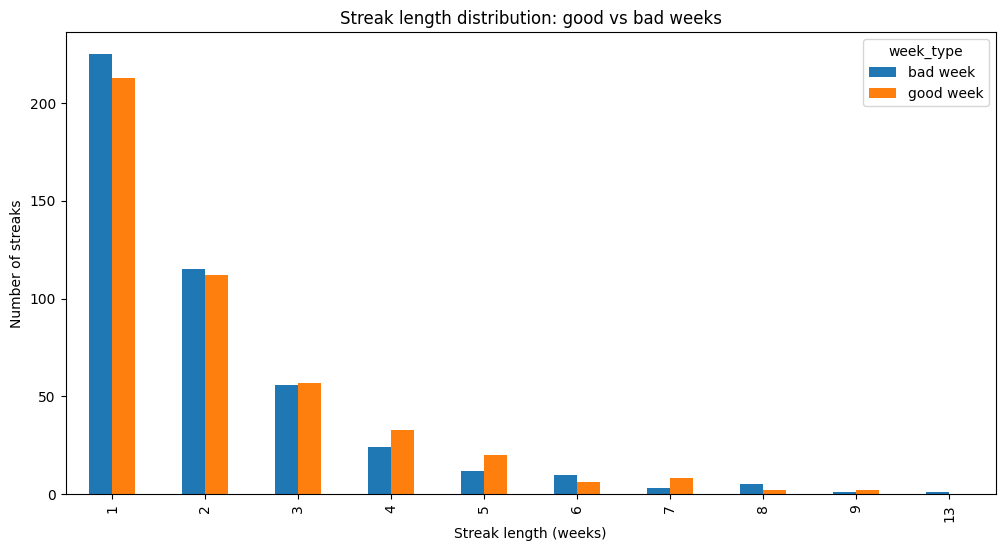

In [15]:
counts = streaks.groupby(['week_type','length']).size().unstack(fill_value=0).T

counts.plot(kind='bar', figsize=(12,6))
plt.xlabel("Streak length (weeks)")
plt.ylabel("Number of streaks")
plt.title("Streak length distribution: good vs bad weeks")
plt.show()


In [16]:
# Normalize the observed counts to make it a proper probability distribution
observed_counts = counts.sum(axis=1)  # Sum of good and bad weeks for each streak length
observed_probs = observed_counts / observed_counts.sum()  # Convert to probabilities
streak_lengths = observed_counts.index  # Streak lengths (1, 2, 3, ...)

# Define the negative log-likelihood function for the geometric distribution
def neg_log_likelihood(p):
    if p <= 0 or p >= 1:
        return np.inf  # Invalid p values
    expected_probs = geom.pmf(streak_lengths, p)  # Geometric distribution probabilities
    expected_probs /= expected_probs.sum()  # Normalize to sum to 1
    return -np.sum(observed_probs * np.log(expected_probs))  # Negative log-likelihood

# Optimize to find the best-fit p
result = minimize(neg_log_likelihood, x0=0.5, bounds=[(0.01, 0.99)])
best_p = result.x[0]

print(f"Estimated probability of heads (p): {best_p}")


Estimated probability of heads (p): 0.4735075829321022


     length  next_bad_length
0         1              2.0
2         1              1.0
4         2              3.0
6         2              2.0
8         1              3.0
..      ...              ...
894       1              1.0
896       3              2.0
898       1              1.0
900       4              1.0
902       5              1.0

[452 rows x 2 columns]


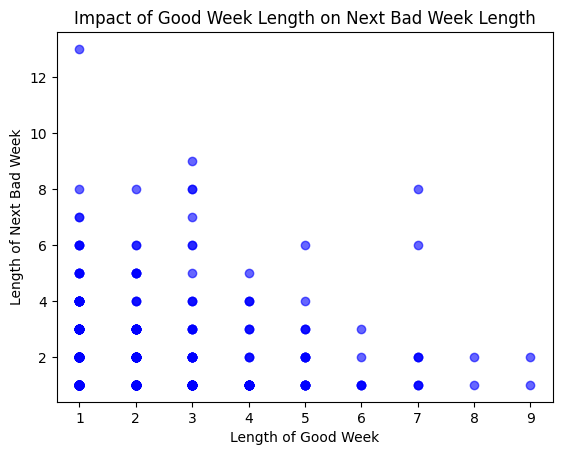

In [17]:
# Shift the lengths of bad weeks to align with the preceding good weeks
streaks['next_bad_length'] = streaks['length'].shift(-1).where(streaks['week_type'] == 'good week')

# Filter only rows where the current streak is a "good week"
good_to_bad = streaks[streaks['week_type'] == 'good week']

# Display the relationship between good week lengths and the next bad week lengths
print(good_to_bad[['length', 'next_bad_length']].dropna())

# Optionally, plot the relationship
plt.scatter(good_to_bad['length'], good_to_bad['next_bad_length'], color='blue', alpha=0.6)
plt.xlabel("Length of Good Week")
plt.ylabel("Length of Next Bad Week")
plt.title("Impact of Good Week Length on Next Bad Week Length")
plt.show()

     length  next_good_length
1         2               1.0
3         1               2.0
5         3               2.0
7         2               1.0
9         3               1.0
..      ...               ...
895       1               3.0
897       2               1.0
899       1               4.0
901       1               5.0
903       1               2.0

[452 rows x 2 columns]


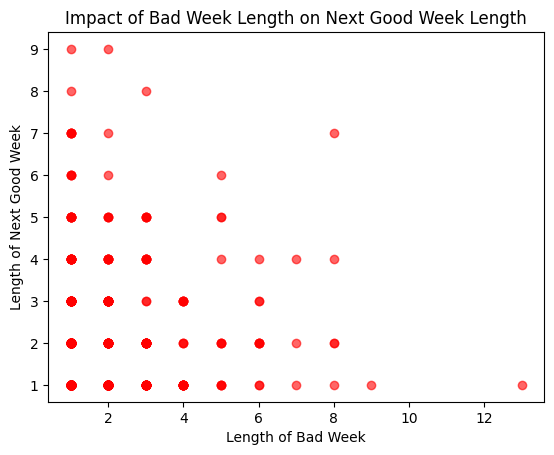

In [18]:
# Shift the lengths of good weeks to align with the preceding bad weeks
streaks['next_good_length'] = streaks['length'].shift(-1).where(streaks['week_type'] == 'bad week')

# Filter only rows where the current streak is a "bad week"
bad_to_good = streaks[streaks['week_type'] == 'bad week']

# Display the relationship between bad week lengths and the next good week lengths
print(bad_to_good[['length', 'next_good_length']].dropna())

# Optionally, plot the relationship
plt.scatter(bad_to_good['length'], bad_to_good['next_good_length'], color='red', alpha=0.6)
plt.xlabel("Length of Bad Week")
plt.ylabel("Length of Next Good Week")
plt.title("Impact of Bad Week Length on Next Good Week Length")
plt.show()

In [19]:
# Filter only rows where the current streak is a "good week"
good_to_bad = streaks[streaks['week_type'] == 'good week']

# Group by the length of good weeks and count the lengths of the subsequent bad weeks
table = (good_to_bad.groupby(['length', 'next_bad_length'])
         .size()
         .unstack(fill_value=0))

print(table)

next_bad_length  1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   13.0
length                                                                     
1                 100    59    27    14     5     4     2     1     0     1
2                  53    30    17     3     5     2     0     1     0     0
3                  31    11     5     3     1     2     1     2     1     0
4                  23     3     3     3     1     0     0     0     0     0
5                   9     6     3     1     0     1     0     0     0     0
6                   4     1     1     0     0     0     0     0     0     0
7                   3     3     0     0     0     1     0     1     0     0
8                   1     1     0     0     0     0     0     0     0     0
9                   1     1     0     0     0     0     0     0     0     0


In [20]:
# Group by the length of bad weeks and count the lengths of the subsequent good weeks
bad_to_good_table = (bad_to_good.groupby(['length', 'next_good_length'])
                     .size()
                     .unstack(fill_value=0))

print(bad_to_good_table)

next_good_length  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0
length                                                       
1                  99   62   29   14    9    4    6    1    1
2                  64   18   18    8    4    1    1    0    1
3                  24   17    2    7    5    0    0    1    0
4                  15    3    6    0    0    0    0    0    0
5                   4    4    0    1    2    1    0    0    0
6                   2    5    2    1    0    0    0    0    0
7                   1    1    0    1    0    0    0    0    0
8                   1    2    0    1    0    0    1    0    0
9                   1    0    0    0    0    0    0    0    0
13                  1    0    0    0    0    0    0    0    0


In [21]:
# Filter rows where the next_bad_length is not NaN
good_to_bad_filtered = good_to_bad.dropna(subset=['next_bad_length'])

# Calculate the correlation
correlation = good_to_bad_filtered['length'].corr(good_to_bad_filtered['next_bad_length'])
print(f"Correlation between length of good streaks and subsequent bad weeks: {correlation}")

Correlation between length of good streaks and subsequent bad weeks: -0.011748411854348424


In [22]:
# Filter rows where the next_good_length is not NaN
bad_to_good_filtered = bad_to_good.dropna(subset=['next_good_length'])

# Calculate the correlation
correlation_bad_to_good = bad_to_good_filtered['length'].corr(bad_to_good_filtered['next_good_length'])
print(f"Correlation between length of bad streaks and subsequent good weeks: {correlation_bad_to_good}")

Correlation between length of bad streaks and subsequent good weeks: 0.0033881256536143125


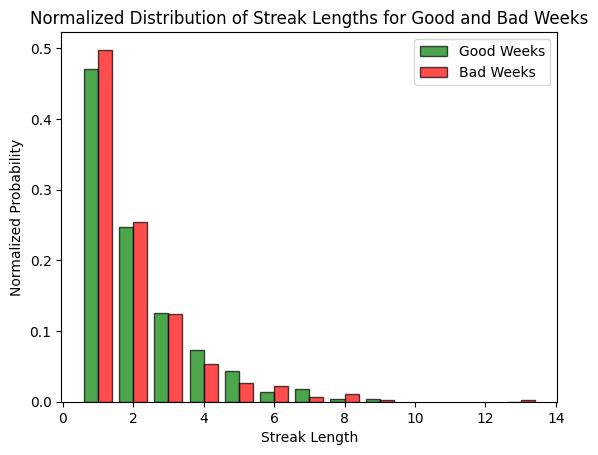

In [23]:
# Separate observed probabilities for good and bad weeks
good_week_probs = counts['good week'] / counts['good week'].sum()
bad_week_probs = counts['bad week'] / counts['bad week'].sum()

# Plot the distributions
plt.bar(streak_lengths - 0.2, good_week_probs, width=0.4, color='green', alpha=0.7, label='Good Weeks', edgecolor='black')
plt.bar(streak_lengths + 0.2, bad_week_probs, width=0.4, color='red', alpha=0.7, label='Bad Weeks', edgecolor='black')

plt.xlabel("Streak Length")
plt.ylabel("Normalized Probability")
plt.title("Normalized Distribution of Streak Lengths for Good and Bad Weeks")
plt.legend()
plt.show()

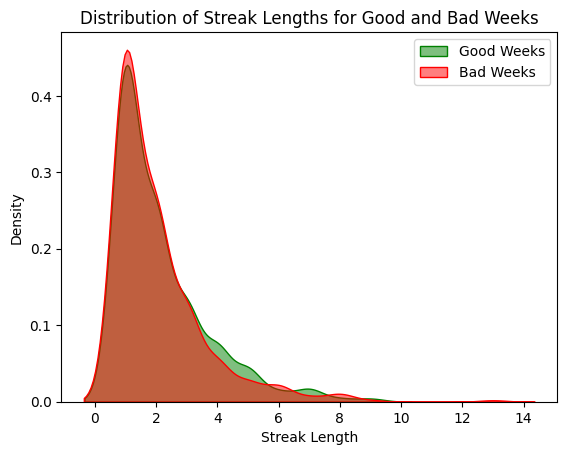

In [24]:
import seaborn as sns

# Import seaborn for KDE plot

# Create a KDE plot for streak lengths of good and bad weeks
sns.kdeplot(data=streaks[streaks['week_type'] == 'good week'], x='length', label='Good Weeks', fill=True, color='green', alpha=0.5)
sns.kdeplot(data=streaks[streaks['week_type'] == 'bad week'], x='length', label='Bad Weeks', fill=True, color='red', alpha=0.5)

# Add labels and title
plt.xlabel("Streak Length")
plt.ylabel("Density")
plt.title("Distribution of Streak Lengths for Good and Bad Weeks")
plt.legend()
plt.show()

In [25]:
def get_good_streak_after_bad(bad_streak_length):
    result = bad_to_good[(bad_to_good['length'] == bad_streak_length) & (bad_to_good['next_good_length'] > 2)]
    return result[['length', 'next_good_length']]

# Example usage:
bad_streak_length = 3  # Replace with the desired bad streak length
good_streaks = get_good_streak_after_bad(bad_streak_length)
print(good_streaks)

     length  next_good_length
31        3               5.0
141       3               4.0
161       3               5.0
239       3               4.0
391       3               4.0
405       3               4.0
441       3               5.0
493       3               5.0
521       3               3.0
553       3               4.0
701       3               4.0
735       3               4.0
757       3               8.0
777       3               5.0
781       3               3.0
